# 다회용기 검증 모델 학습

이 노트북은 용기 이미지를 **일회용(disposable)** vs **다회용(reusable)**으로 분류하는 모델을 학습합니다.

## 데이터셋 구조
```
data_preprocessed/container_type/
├── disposable/  (일회용)
└── reusable/    (다회용)
```

## 모델 아키텍처
- **베이스 모델**: EfficientNet-B0 (ImageNet pretrained)
- **분류**: Binary classification (disposable vs reusable)
- **데이터 증강**: 회전, 뒤집기, 밝기 조정 등

## 1. 환경 설정 및 라이브러리 import

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 2060
Memory: 6.01 GB


## 🔧 GPU 메모리 관리 (필요시 사용)

학습 중 GPU 메모리 부족 시 아래 셀을 실행하세요.

In [ ]:
# GPU 메모리 유틸리티 import
import sys
sys.path.append('/app')
from notebooks.gpu_memory_utils import clear_gpu_memory, print_gpu_memory

# 현재 GPU 메모리 상태 확인
print_gpu_memory()

# GPU 메모리 정리 (필요시 주석 해제)
# clear_gpu_memory()

## 2. 하이퍼파라미터 설정

In [2]:
# 경로 설정
DATA_DIR = Path('/app/data_preprocessed/container_type')
MODEL_SAVE_DIR = Path('/app/models/weights')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 학습 하이퍼파라미터
BATCH_SIZE = 16  # GPU 메모리 절약을 위해 감소
IMG_SIZE = 224
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
TRAIN_RATIO = 0.8
PATIENCE = 10  # Early stopping patience

# 클래스 정의
CLASSES = ['disposable', 'reusable']
NUM_CLASSES = len(CLASSES)

print(f"Data directory: {DATA_DIR}")
print(f"Model save directory: {MODEL_SAVE_DIR}")
print(f"Classes: {CLASSES}")
print(f"Batch size: {BATCH_SIZE}, Image size: {IMG_SIZE}")
print(f"Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}")

Data directory: /app/data_preprocessed/container_type
Model save directory: /app/models/weights
Classes: ['disposable', 'reusable']
Batch size: 32, Image size: 224
Epochs: 50, Learning rate: 0.0001


## 3. 데이터셋 클래스 정의

In [3]:
class ContainerTypeDataset(Dataset):
    """용기 타입 분류 데이터셋"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.classes = CLASSES
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 이미지 경로와 레이블 수집
        self.samples = []
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
                
            for img_path in class_dir.glob('*.png'):
                self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        print(f"Total samples: {len(self.samples)}")
        
        # 클래스별 개수 출력
        class_counts = {cls: 0 for cls in self.classes}
        for _, label in self.samples:
            class_counts[self.classes[label]] += 1
        print("Class distribution:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # 이미지 로드
        image = Image.open(img_path).convert('RGB')
        
        # Transform 적용
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 4. 데이터 증강 및 전처리

In [4]:
# Training transform (데이터 증강)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined")

Transforms defined


## 5. 데이터셋 로드 및 분할

In [5]:
# 전체 데이터셋 로드 (transform 없이)
full_dataset = ContainerTypeDataset(DATA_DIR, transform=None)

# Train/Val 분할
train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_indices, val_indices = random_split(
    range(len(full_dataset)), 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Transform 적용한 데이터셋 생성
class SubsetDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[self.indices[idx]]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SubsetDataset(full_dataset, train_indices.indices, train_transform)
val_dataset = SubsetDataset(full_dataset, val_indices.indices, val_transform)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Total samples: 232
Class distribution:
  disposable: 58
  reusable: 174

Train samples: 185
Validation samples: 47
Train batches: 6
Val batches: 2


## 6. 샘플 이미지 시각화

Training samples:


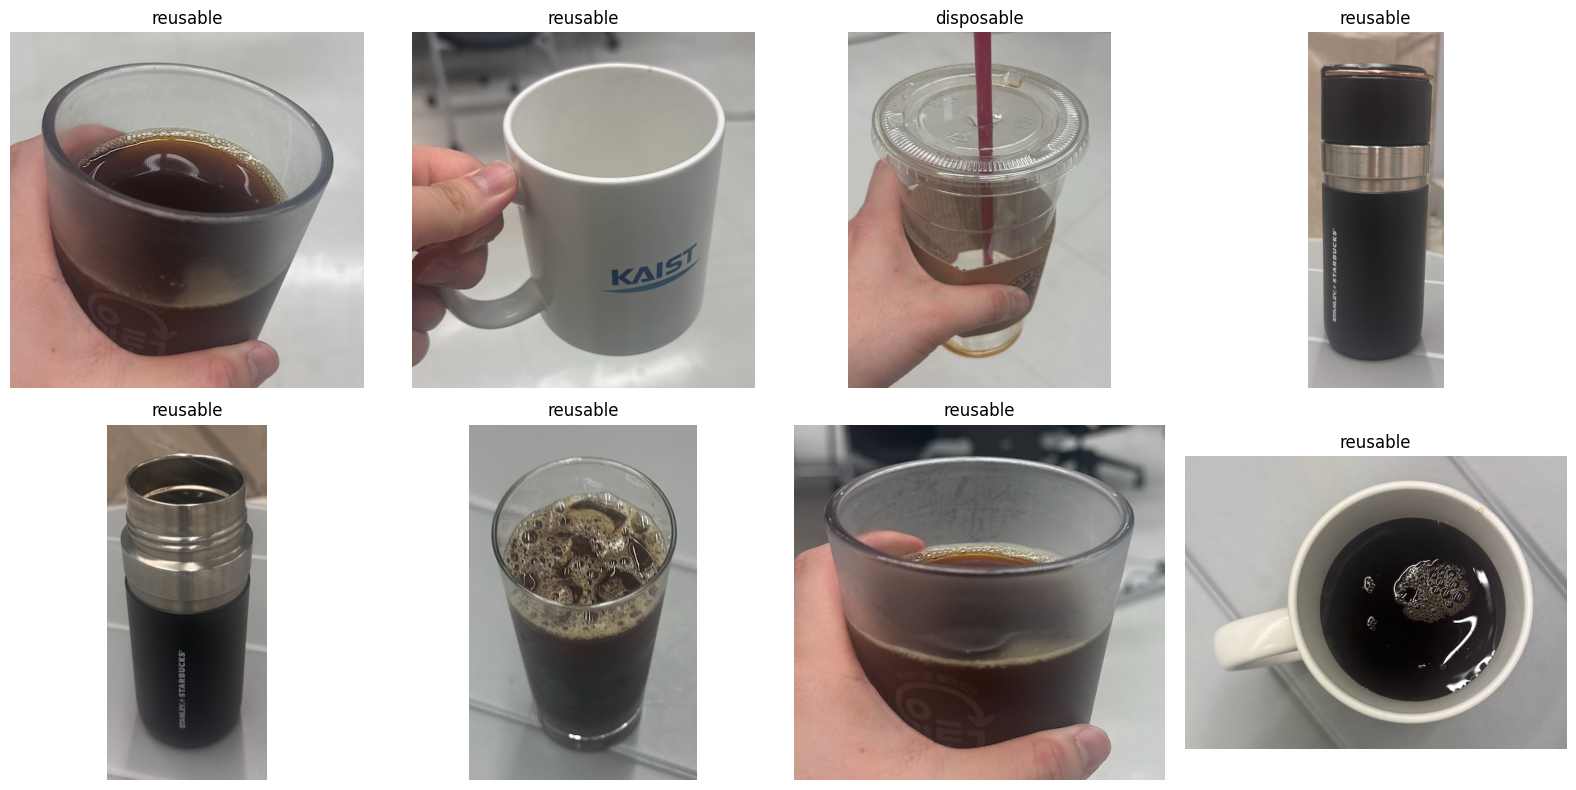

In [6]:
# 샘플 이미지 시각화
def show_samples(dataset, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(n_samples, len(dataset))):
        img_path, label = dataset.dataset.samples[dataset.indices[i]]
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{CLASSES[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Training samples:")
show_samples(train_dataset)

## 7. 모델 정의

In [7]:
class ReusableClassifier(nn.Module):
    """다회용기 분류 모델 (EfficientNet-B0 기반)"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(ReusableClassifier, self).__init__()
        
        # EfficientNet-B0 백본
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        
        # 마지막 FC layer 교체
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# 모델 생성
model = ReusableClassifier(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(device)

print(f"Model created and moved to {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 37.7MB/s]


Model created and moved to cuda
Total parameters: 4,010,110
Trainable parameters: 4,010,110


## 8. Loss, Optimizer, Scheduler 설정

In [8]:
# 클래스 가중치 계산 (불균형 데이터 대응)
class_counts = [0] * NUM_CLASSES
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = [len(train_dataset) / count for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Loss, optimizer, and scheduler configured")

Class counts: [46, 139]
Class weights: tensor([4.0217, 1.3309], device='cuda:0')
Loss, optimizer, and scheduler configured


## 9. 학습 및 검증 함수

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """1 epoch 학습"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """1 epoch 검증"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training and validation functions defined")

Training and validation functions defined


## 10. 학습 루프

In [10]:
# 학습 히스토리 저장
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"{'='*60}")
    
    # 학습
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 검증
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 결과 출력
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Best model 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        # 모델 저장
        save_path = MODEL_SAVE_DIR / 'reusable_classifier_best.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, save_path)
        print(f"✅ Best model saved! (Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Best Val Acc: {best_val_acc:.2f}%")
print(f"{'='*60}")

Starting training...


Epoch [1/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s, loss=0.4837, acc=63.83%]



Train Loss: 0.6532, Train Acc: 52.97%
Val Loss: 0.5081, Val Acc: 63.83%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.5081, Val Acc: 63.83%)

Epoch [2/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s, loss=0.3612, acc=87.23%]



Train Loss: 0.5041, Train Acc: 77.84%
Val Loss: 0.3784, Val Acc: 87.23%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.3784, Val Acc: 87.23%)

Epoch [3/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.16it/s, loss=0.2523, acc=93.62%]



Train Loss: 0.3665, Train Acc: 90.81%
Val Loss: 0.2773, Val Acc: 93.62%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.2773, Val Acc: 93.62%)

Epoch [4/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s, loss=0.1759, acc=93.62%]



Train Loss: 0.3255, Train Acc: 88.65%
Val Loss: 0.2047, Val Acc: 93.62%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.2047, Val Acc: 93.62%)

Epoch [5/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.16it/s, loss=0.1275, acc=95.74%]



Train Loss: 0.2205, Train Acc: 96.76%
Val Loss: 0.1539, Val Acc: 95.74%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.1539, Val Acc: 95.74%)

Epoch [6/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.00it/s, loss=0.0972, acc=97.87%]



Train Loss: 0.1684, Train Acc: 97.84%
Val Loss: 0.1198, Val Acc: 97.87%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.1198, Val Acc: 97.87%)

Epoch [7/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s, loss=0.0787, acc=100.00%]



Train Loss: 0.1263, Train Acc: 99.46%
Val Loss: 0.0982, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0982, Val Acc: 100.00%)

Epoch [8/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s, loss=0.0665, acc=100.00%]



Train Loss: 0.1226, Train Acc: 98.92%
Val Loss: 0.0839, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0839, Val Acc: 100.00%)

Epoch [9/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.10it/s, loss=0.0570, acc=100.00%]



Train Loss: 0.0655, Train Acc: 100.00%
Val Loss: 0.0708, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0708, Val Acc: 100.00%)

Epoch [10/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.93it/s, loss=0.0478, acc=100.00%]



Train Loss: 0.0681, Train Acc: 99.46%
Val Loss: 0.0594, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0594, Val Acc: 100.00%)

Epoch [11/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s, loss=0.0418, acc=100.00%]



Train Loss: 0.0420, Train Acc: 100.00%
Val Loss: 0.0516, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0516, Val Acc: 100.00%)

Epoch [12/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s, loss=0.0365, acc=100.00%]



Train Loss: 0.0381, Train Acc: 100.00%
Val Loss: 0.0445, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0445, Val Acc: 100.00%)

Epoch [13/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.10it/s, loss=0.0322, acc=100.00%]



Train Loss: 0.0378, Train Acc: 100.00%
Val Loss: 0.0380, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0380, Val Acc: 100.00%)

Epoch [14/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s, loss=0.0293, acc=100.00%]



Train Loss: 0.0389, Train Acc: 100.00%
Val Loss: 0.0331, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0331, Val Acc: 100.00%)

Epoch [15/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.08it/s, loss=0.0276, acc=100.00%]



Train Loss: 0.0243, Train Acc: 100.00%
Val Loss: 0.0311, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0311, Val Acc: 100.00%)

Epoch [16/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s, loss=0.0252, acc=100.00%]



Train Loss: 0.0254, Train Acc: 100.00%
Val Loss: 0.0288, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0288, Val Acc: 100.00%)

Epoch [17/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s, loss=0.0244, acc=100.00%]



Train Loss: 0.0157, Train Acc: 100.00%
Val Loss: 0.0277, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0277, Val Acc: 100.00%)

Epoch [18/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.66it/s, loss=0.0232, acc=100.00%]



Train Loss: 0.0117, Train Acc: 100.00%
Val Loss: 0.0268, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0268, Val Acc: 100.00%)

Epoch [19/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s, loss=0.0219, acc=100.00%]



Train Loss: 0.0164, Train Acc: 100.00%
Val Loss: 0.0256, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0256, Val Acc: 100.00%)

Epoch [20/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s, loss=0.0194, acc=100.00%]



Train Loss: 0.0223, Train Acc: 98.92%
Val Loss: 0.0225, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0225, Val Acc: 100.00%)

Epoch [21/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s, loss=0.0187, acc=100.00%]



Train Loss: 0.0107, Train Acc: 100.00%
Val Loss: 0.0223, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0223, Val Acc: 100.00%)

Epoch [22/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s, loss=0.0173, acc=100.00%]



Train Loss: 0.0119, Train Acc: 100.00%
Val Loss: 0.0206, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0206, Val Acc: 100.00%)

Epoch [23/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s, loss=0.0157, acc=100.00%]



Train Loss: 0.0087, Train Acc: 100.00%
Val Loss: 0.0190, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0190, Val Acc: 100.00%)

Epoch [24/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.94it/s, loss=0.0146, acc=100.00%]



Train Loss: 0.0078, Train Acc: 100.00%
Val Loss: 0.0182, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0182, Val Acc: 100.00%)

Epoch [25/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s, loss=0.0142, acc=100.00%]



Train Loss: 0.0059, Train Acc: 100.00%
Val Loss: 0.0172, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0172, Val Acc: 100.00%)

Epoch [26/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s, loss=0.0143, acc=100.00%]



Train Loss: 0.0108, Train Acc: 100.00%
Val Loss: 0.0160, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0160, Val Acc: 100.00%)

Epoch [27/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s, loss=0.0130, acc=100.00%]



Train Loss: 0.0093, Train Acc: 100.00%
Val Loss: 0.0149, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0149, Val Acc: 100.00%)

Epoch [28/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s, loss=0.0128, acc=100.00%]



Train Loss: 0.0095, Train Acc: 100.00%
Val Loss: 0.0138, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0138, Val Acc: 100.00%)

Epoch [29/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s, loss=0.0123, acc=100.00%]



Train Loss: 0.0052, Train Acc: 100.00%
Val Loss: 0.0136, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0136, Val Acc: 100.00%)

Epoch [30/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s, loss=0.0113, acc=100.00%]



Train Loss: 0.0059, Train Acc: 100.00%
Val Loss: 0.0130, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0130, Val Acc: 100.00%)

Epoch [31/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s, loss=0.0107, acc=100.00%]



Train Loss: 0.0051, Train Acc: 100.00%
Val Loss: 0.0123, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0123, Val Acc: 100.00%)

Epoch [32/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.93it/s, loss=0.0109, acc=100.00%]



Train Loss: 0.0040, Train Acc: 100.00%
Val Loss: 0.0129, Val Acc: 100.00%
Current LR: 0.000100
No improvement. Patience: 1/10

Epoch [33/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.60it/s, loss=0.0105, acc=100.00%]



Train Loss: 0.0034, Train Acc: 100.00%
Val Loss: 0.0128, Val Acc: 100.00%
Current LR: 0.000100
No improvement. Patience: 2/10

Epoch [34/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.69it/s, loss=0.0098, acc=100.00%]



Train Loss: 0.0064, Train Acc: 100.00%
Val Loss: 0.0124, Val Acc: 100.00%
Current LR: 0.000100
No improvement. Patience: 3/10

Epoch [35/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.53it/s, loss=0.0090, acc=100.00%]



Train Loss: 0.0047, Train Acc: 100.00%
Val Loss: 0.0113, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0113, Val Acc: 100.00%)

Epoch [36/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s, loss=0.0090, acc=100.00%]



Train Loss: 0.0039, Train Acc: 100.00%
Val Loss: 0.0116, Val Acc: 100.00%
Current LR: 0.000100
No improvement. Patience: 1/10

Epoch [37/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s, loss=0.0091, acc=100.00%]



Train Loss: 0.0024, Train Acc: 100.00%
Val Loss: 0.0112, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0112, Val Acc: 100.00%)

Epoch [38/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s, loss=0.0085, acc=100.00%]



Train Loss: 0.0030, Train Acc: 100.00%
Val Loss: 0.0109, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0109, Val Acc: 100.00%)

Epoch [39/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s, loss=0.0085, acc=100.00%]



Train Loss: 0.0030, Train Acc: 100.00%
Val Loss: 0.0106, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0106, Val Acc: 100.00%)

Epoch [40/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s, loss=0.0076, acc=100.00%]



Train Loss: 0.0035, Train Acc: 100.00%
Val Loss: 0.0100, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0100, Val Acc: 100.00%)

Epoch [41/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s, loss=0.0074, acc=100.00%]



Train Loss: 0.0030, Train Acc: 100.00%
Val Loss: 0.0092, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0092, Val Acc: 100.00%)

Epoch [42/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s, loss=0.0076, acc=100.00%]



Train Loss: 0.0020, Train Acc: 100.00%
Val Loss: 0.0100, Val Acc: 100.00%
Current LR: 0.000100
No improvement. Patience: 1/10

Epoch [43/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s, loss=0.0081, acc=100.00%]



Train Loss: 0.0032, Train Acc: 100.00%
Val Loss: 0.0092, Val Acc: 100.00%
Current LR: 0.000100
No improvement. Patience: 2/10

Epoch [44/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s, loss=0.0076, acc=100.00%]



Train Loss: 0.0032, Train Acc: 100.00%
Val Loss: 0.0090, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0090, Val Acc: 100.00%)

Epoch [45/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s, loss=0.0074, acc=100.00%]



Train Loss: 0.0034, Train Acc: 100.00%
Val Loss: 0.0087, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0087, Val Acc: 100.00%)

Epoch [46/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s, loss=0.0075, acc=100.00%]



Train Loss: 0.0046, Train Acc: 100.00%
Val Loss: 0.0083, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0083, Val Acc: 100.00%)

Epoch [47/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s, loss=0.0072, acc=100.00%]



Train Loss: 0.0017, Train Acc: 100.00%
Val Loss: 0.0081, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0081, Val Acc: 100.00%)

Epoch [48/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.57it/s, loss=0.0069, acc=100.00%]



Train Loss: 0.0017, Train Acc: 100.00%
Val Loss: 0.0079, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0079, Val Acc: 100.00%)

Epoch [49/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s, loss=0.0069, acc=100.00%]



Train Loss: 0.0084, Train Acc: 100.00%
Val Loss: 0.0076, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0076, Val Acc: 100.00%)

Epoch [50/50]


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s, loss=0.0070, acc=100.00%]


Train Loss: 0.0021, Train Acc: 100.00%
Val Loss: 0.0064, Val Acc: 100.00%
Current LR: 0.000100
✅ Best model saved! (Val Loss: 0.0064, Val Acc: 100.00%)

Training completed!
Best Val Loss: 0.0064
Best Val Acc: 100.00%


## 11. 학습 곡선 시각화

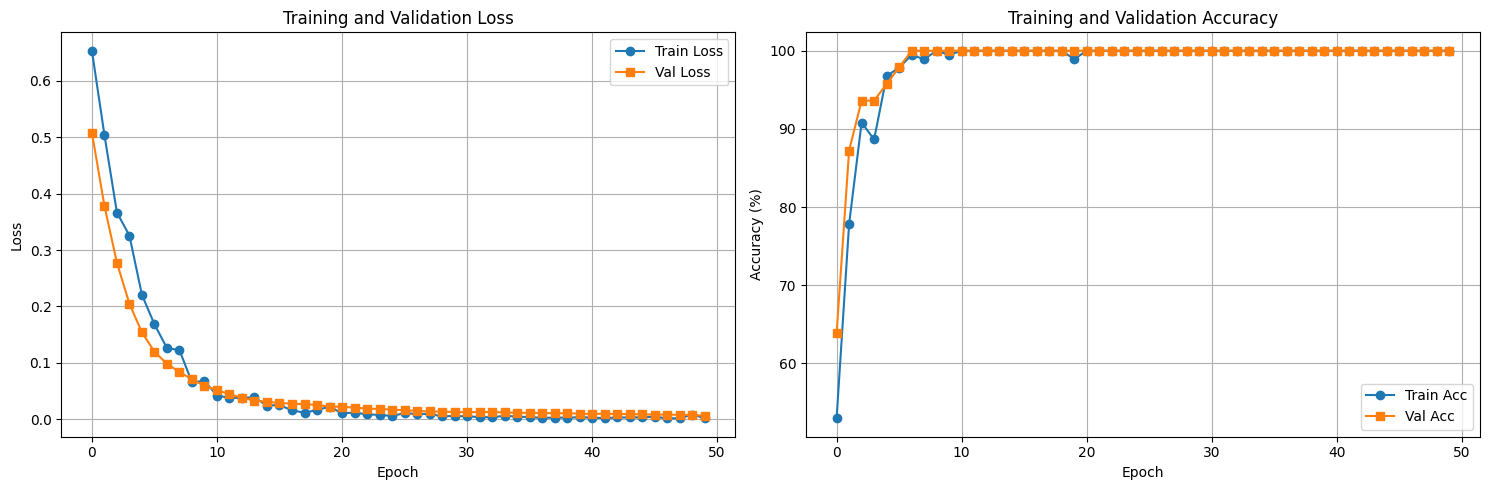

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss 곡선
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy 곡선
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. 최종 모델 평가

In [12]:
# Best model 로드
checkpoint = torch.load(MODEL_SAVE_DIR / 'reusable_classifier_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded (Epoch {checkpoint['epoch']+1})")

# 최종 평가
val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

print(f"\nFinal Validation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.2f}%")

# Classification Report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(val_labels, val_preds, target_names=CLASSES, digits=4))

Best model loaded (Epoch 50)


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.46it/s, loss=0.0070, acc=100.00%]


Final Validation Results:
Loss: 0.0064
Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

  disposable     1.0000    1.0000    1.0000        12
    reusable     1.0000    1.0000    1.0000        35

    accuracy                         1.0000        47
   macro avg     1.0000    1.0000    1.0000        47
weighted avg     1.0000    1.0000    1.0000        47



## 13. Confusion Matrix 시각화

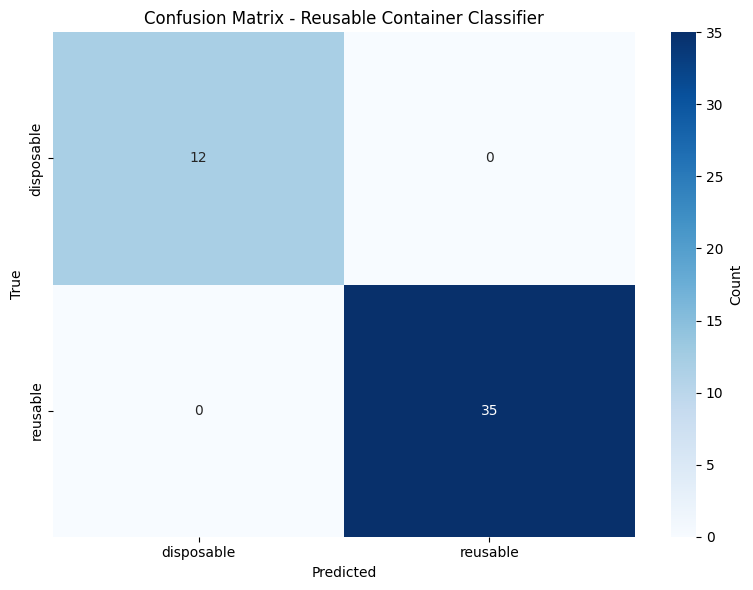

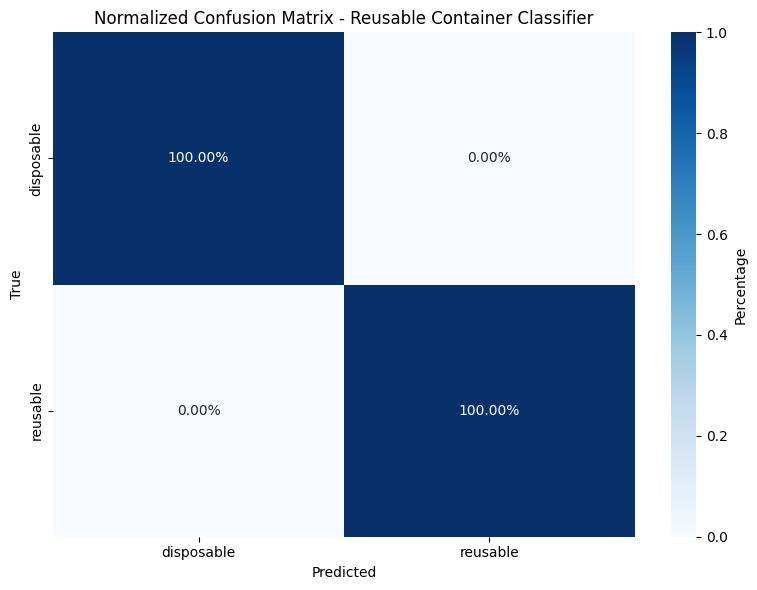

In [13]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Reusable Container Classifier')
plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix - Reusable Container Classifier')
plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. 학습 메타데이터 저장

In [14]:
# 메타데이터 저장
metadata = {
    'model_name': 'reusable_classifier',
    'architecture': 'EfficientNet-B0',
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history['train_loss']),
    'learning_rate': LEARNING_RATE,
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'class_counts': class_counts,
}

with open(MODEL_SAVE_DIR / 'reusable_classifier_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved to reusable_classifier_metadata.json")
print(json.dumps(metadata, indent=2))

Metadata saved to reusable_classifier_metadata.json
{
  "model_name": "reusable_classifier",
  "architecture": "EfficientNet-B0",
  "num_classes": 2,
  "classes": [
    "disposable",
    "reusable"
  ],
  "img_size": 224,
  "batch_size": 32,
  "epochs_trained": 50,
  "learning_rate": 0.0001,
  "best_val_loss": 0.006378928432241082,
  "best_val_acc": 100.0,
  "train_samples": 185,
  "val_samples": 47,
  "class_counts": [
    46,
    139
  ]
}


## 15. 샘플 예측 시각화

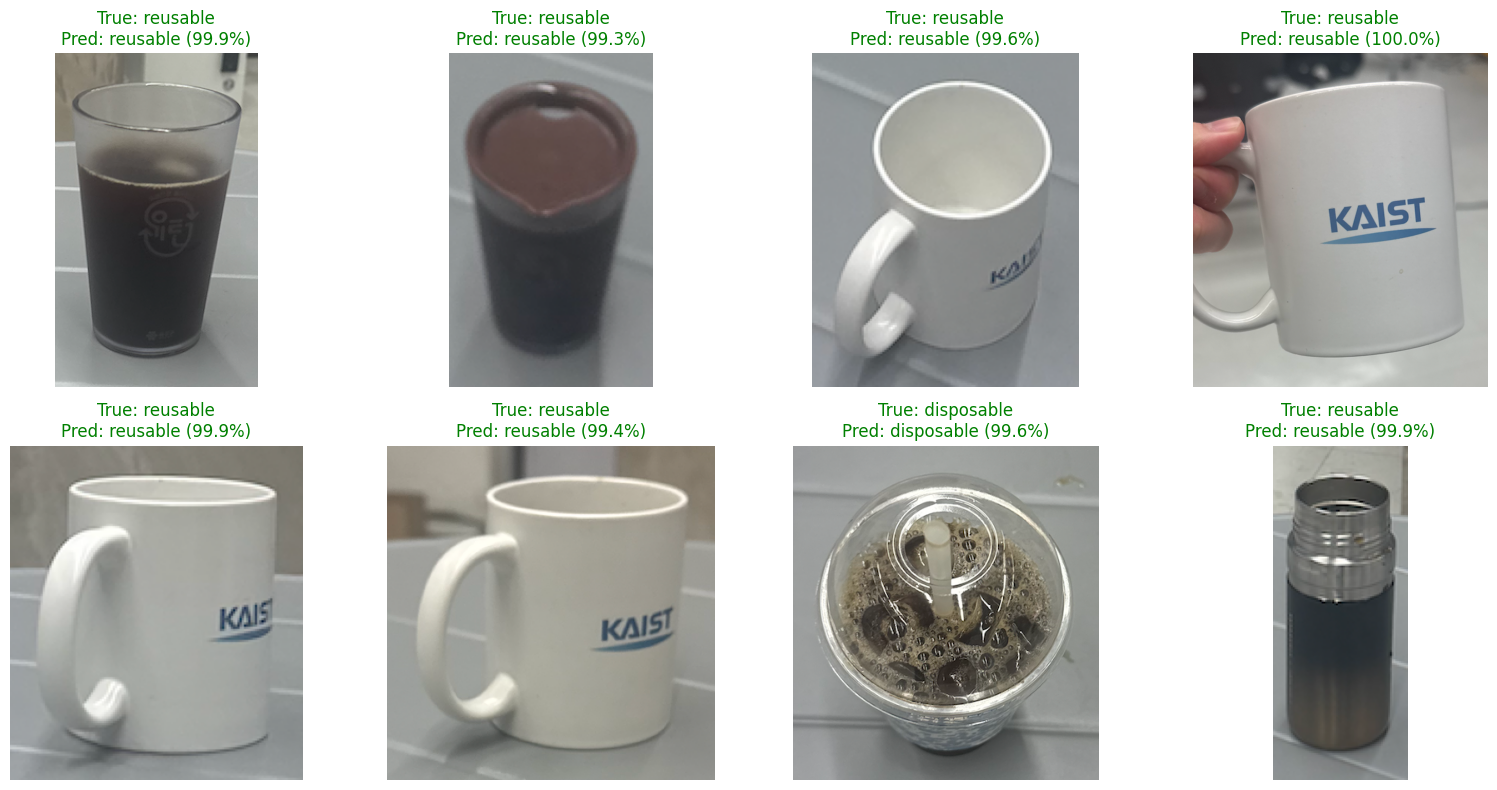

In [15]:
# 샘플 예측 시각화
model.eval()

# 샘플 선택 (validation set에서)
n_samples = 8
sample_indices = np.random.choice(len(val_dataset), n_samples, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    img_path, true_label = val_dataset.dataset.samples[val_dataset.indices[idx]]
    img = Image.open(img_path).convert('RGB')
    
    # 예측
    img_tensor = val_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_label].item()
    
    # 시각화
    axes[i].imshow(img)
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(
        f"True: {CLASSES[true_label]}\nPred: {CLASSES[pred_label]} ({confidence*100:.1f}%)",
        color=color
    )
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'reusable_classifier_sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 완료!

다회용기 분류 모델 학습이 완료되었습니다.

### 저장된 파일:
- `models/weights/reusable_classifier_best.pth` - 최고 성능 모델
- `models/weights/reusable_classifier_metadata.json` - 모델 메타데이터
- `models/weights/reusable_classifier_*.png` - 학습 곡선, confusion matrix 등